<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/TextClassifierDistilbertGerman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying News Articles with Bert

based on https://www.philschmid.de/bert-text-classification-in-a-different-language/ which applies `distilbert-base-german-cased` model on the [Germeval 2019](hhttps://projects.fzai.h-da.de/iggsa/projekt/) dataset to identify offensive language in German tweets.

Following we will use `distilbert-base-german-cased` on the 10k German News Articles dataset to classify 9 news topics.

## Prerequisites

In [1]:
# install simpletransformers
!pip install -q simpletransformers > /dev/null

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.61.4

ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.3 which is incompatible.
ERROR: datasets 1.5.0 has requirement tqdm<4.50.0,>=4.27, but you'll have tqdm 4.60.0 which is incompatible.
simpletransformers==0.61.4


## Download Data

In [2]:
!mkdir -p data
!wget https://github.com/tblock/10kGNAD/blob/master/train.csv?raw=true -nv -O data/train.csv
!wget https://github.com/tblock/10kGNAD/blob/master/test.csv?raw=true -nv -O data/test.csv
!ls -Ah data

2021-04-18 21:38:42 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv [24405789/24405789] -> "data/train.csv" [1]
2021-04-18 21:38:43 URL:https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv [2755020/2755020] -> "data/test.csv" [1]
total 26M
drwxr-xr-x 2 root root 4.0K Apr 18 21:38 .
drwxr-xr-x 1 root root 4.0K Apr 18 21:38 ..
-rw-r--r-- 1 root root 2.7M Apr 18 21:38 test.csv
-rw-r--r-- 1 root root  24M Apr 18 21:38 train.csv


## Import Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
data_dir = Path("data/")

train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'

In [5]:
def load_file(filepath: Path) -> pd.DataFrame:
    f = pd.read_csv(filepath, sep=";", quotechar="'", names=['labels', 'text'])
    return f

In [6]:
train_df = load_file(data_dir / 'train.csv')
print(train_df.shape[0], 'articles')
display(train_df.head())

9245 articles


,labels,text
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...


## Analyse Dataset

* Imbalanced classes
* Text length

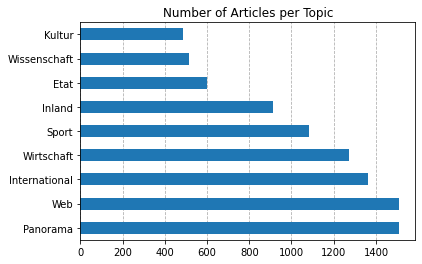

In [7]:
train_df.labels.value_counts().plot.barh(title="Number of Articles per Topic", zorder=2)
plt.gca().xaxis.grid(True, linestyle='--');

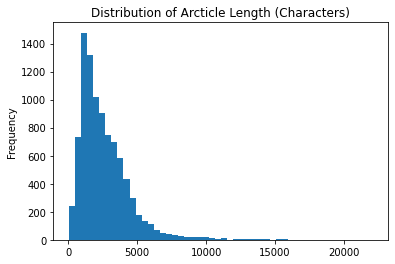

In [8]:
train_df.text.map(lambda x: len(x)).plot.hist(bins=50, title="Distribution of Arcticle Length (Characters)");

## Prepare for Model Training

Requirements of SimpleTransformers

* columns should be labeled `labels` and `text`
* labels must be int values starting at `0`

In [9]:
# compute weights for training (where least frequent class has weight 1.0)
train_weights_s = (train_df
                   .labels
                   .value_counts()
                   .pipe(lambda x: 1 / (x / x.min()))
)
train_weights_s

Panorama         0.321192
Web              0.321405
International    0.356618
Wirtschaft       0.381890
Sport            0.448659
Inland           0.531216
Etat             0.806988
Wissenschaft     0.939922
Kultur           1.000000
Name: labels, dtype: float64

In [10]:
# map label to integers
mapping_s = pd.Series(train_weights_s.index)
mapping_s

0         Panorama
1              Web
2    International
3       Wirtschaft
4            Sport
5           Inland
6             Etat
7     Wissenschaft
8           Kultur
dtype: object

In [11]:
# truncate text
train_df.text = train_df.text.map(lambda x: x[:2000])

In [12]:
train_df.labels.replace(mapping_s.values, mapping_s.index, inplace=True)
display(train_df.head())

,labels,text
0,4,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,8,"Erfundene Bilder zu Filmen, die als verloren g..."
2,1,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,3,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,5,Estland sieht den künftigen österreichischen P...


In [13]:
# load test dataset
test_df = load_file(data_dir / 'test.csv')
test_df.labels.replace(mapping_s.values, mapping_s.index, inplace=True)
print(test_df.shape[0], 'articles')
display(test_df.head())

1028 articles


,labels,text
0,3,"Die Gewerkschaft GPA-djp lanciert den ""All-in-..."
1,4,Franzosen verteidigen 2:1-Führung – Kritische ...
2,1,Neues Video von Designern macht im Netz die Ru...
3,4,23-jähriger Brasilianer muss vier Spiele pausi...
4,2,Aufständische verwendeten Chemikalie bei Gefec...


## Train Model

In [14]:
project_name = "german_news_article_classification"

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [15]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "fp16": False,
             "num_train_epochs": 4,
             "weight": train_weights_s.values,
             "evaluate_during_training": True,
             "overwrite_output_dir": True,
             "wandb_project": project_name}

# Create a ClassificationModel
model = ClassificationModel(
     "distilbert", "distilbert-base-german-cased",
     num_labels=9,
     args=train_args
 )

Downloading:   0%|          | 0.00/464 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/270M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias

Downloading:   0%|          | 0.00/240k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [16]:
from sklearn.metrics import f1_score, accuracy_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

In [17]:
model.train_model(train_df, eval_df=test_df, f1=f1_multiclass, acc=accuracy_score)
wandb.finish()

  0%|          | 0/9245 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/1156 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:760: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/1028 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

Training loss,0.00168
lr,0.0
global_step,4624
_runtime,595
_timestamp,1618782563
_step,97
mcc,0.87737
train_loss,1.13028
eval_loss,0.60819
f1,0.893
acc,0.893


Training loss,█▆▃▄▆▄▂▁▄▃▂▁▂▃▄▄▄▁▃▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
lr,▂▅▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
mcc,▁▅▃███
train_loss,▃▁▁▁▁█
eval_loss,▁▂▄▆██
f1,▁▅▃███
acc,▁▅▃███


In [18]:
result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)

  0%|          | 0/1028 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/129 [00:00<?, ?it/s]

wandb: Currently logged in as: goerlitz (use `wandb login --relogin` to force relogin)


In [19]:
pd.Series(result)

mcc          0.877370
f1           0.892996
acc          0.892996
eval_loss    0.608193
dtype: float64